# LSTM Implementation

# **Text Preprocessing**

In [3]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import nltk
import re

In [4]:
# Specify the filename
input_file = '/content/sample_data/holmes.txt'

# Read the contents of the file
with open(input_file, 'r', encoding='utf-8') as infile:
    data = infile.read()

In [5]:
data[:100] # view first few characters

"*Project Gutenberg's Etext of Tom Swift And His Submarine Boat*\n\n#4 in the Victor Appleton's Tom Swi"

In [6]:
# Limit data to 500000 characters
data = data[:500000]

# Clean Text

In [7]:
# Function to remove emojis and special characters from text
def remove_emojis_and_special_characters(text):
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)

    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Remove extra spaces
    text = re.sub(' +', ' ', text)

    return text

In [8]:
# Preprocessing pipeline
def preprocess_pipeline(data) -> 'list':
    # Split by newline character
    sentences = data.split('\n')
    for i in range(len(sentences)):
        sentences[i] = remove_emojis_and_special_characters(sentences[i])
    # Remove leading and trailing spaces
    sentences = [s.strip() for s in sentences]
    # Drop empty sentences
    sentences = [s for s in sentences if len(s) > 0]
    # Tokenization
    tokenized = []
    for sentence in sentences:
        # Convert to lowercase
        sentence = sentence.lower()
        tokenized.append(sentence)
    return tokenized

# Tokenize sentences
tokenized_sentences = preprocess_pipeline(data)

In [9]:
"""
What is an OOV Token?
An out-of-vocabulary (OOV) token is a special token used in natural language processing (NLP) tasks to represent words that
are not present in the vocabulary of the model or tokenizer. When a word that is not in the vocabulary is encountered during
tokenization or text processing, it is replaced with the OOV token.

Why Use an OOV Token?
Using an OOV token helps handle unseen or unknown words during the training or inference phase of an NLP model.
Instead of encountering errors or issues when encountering unknown words, the model can gracefully handle them by
representing them with the OOV token. This is particularly useful when working with real-world data where the vocabulary
of the model may not cover all possible words.
"""
# Tokenize words
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(tokenized_sentences)
total_words = len(tokenizer.word_index) + 1
# tokenizer.word_counts
# tokenizer.word_index
"""
n_gram example:
[3, 15, 8, 7, 20, 12, 6]

For the above sentece sentence, the code would generate the following n-gram sequences:

[3, 15]
[3, 15, 8]
[3, 15, 8, 7]
[3, 15, 8, 7, 20]
[3, 15, 8, 7, 20, 12]
[3, 15, 8, 7, 20, 12, 6]
"""

# Generate input sequences
input_sequences = []
for line in tokenized_sentences:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i + 1]
        input_sequences.append(n_gram_sequence)

# Pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [10]:
# Creates labels with input sequences
X,labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [11]:
# Split data into training, validation, and test sets
from sklearn.model_selection import train_test_split
X_train_temp, X_val_test, y_train_temp, y_val_test = train_test_split(X, ys, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Train LSTM Model

In [12]:
# Define your model
model = Sequential()
model.add(Embedding(total_words, 100))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))

adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Train the model
history = model.fit(X_train_temp, y_train_temp, epochs=50, validation_data=(X_val, y_val), verbose=1)

Epoch 1/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.0974 - loss: 6.2889 - val_accuracy: 0.1355 - val_loss: 5.6423
Epoch 2/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.1522 - loss: 5.1656 - val_accuracy: 0.1541 - val_loss: 5.6274
Epoch 3/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.1822 - loss: 4.6153 - val_accuracy: 0.1528 - val_loss: 5.7508
Epoch 4/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.2012 - loss: 4.2606 - val_accuracy: 0.1550 - val_loss: 5.9625
Epoch 5/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.2206 - loss: 3.9643 - val_accuracy: 0.1563 - val_loss: 6.1693
Epoch 6/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.2367 - loss: 3.7782 - val_accuracy: 0.1511 - val_loss: 6.3958
Epoch 7/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.2445 - loss: 3.6613 - val_accuracy: 0.1555 - val_loss: 6.5858
Epoch 8/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.2595 - loss:

# Save Models (Weights and biases)

In [23]:
# Save model architecture as JSON file
from tensorflow.keras.models import model_from_json

model_json = model.to_json()
with open("lstm_model.json", "w") as json_file:
    json_file.write(model_json)

In [24]:
# Load model architecture from JSON file
from tensorflow.keras.models import model_from_json

with open("lstm_model.json", "r") as json_file:
    loaded_model_json = json_file.read()

# Create model from loaded architecture
loaded_model = model_from_json(loaded_model_json)

print("Model architecture loaded successfully from JSON file.")

Model architecture loaded successfully from JSON file.


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


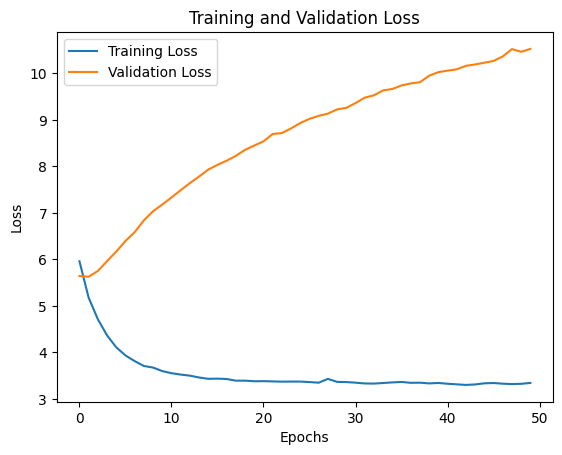

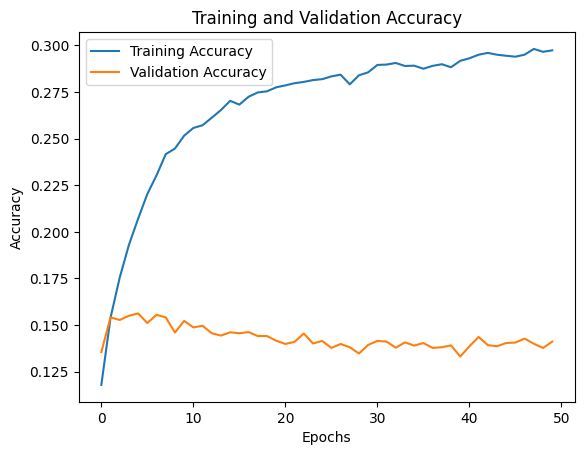

In [16]:

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Inferences

In [17]:
# def predict_top_five_words(model, tokenizer, seed_text):
#     token_list = tokenizer.texts_to_sequences([seed_text])[0]
#     token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
#     predicted = model.predict(token_list, verbose=0)
#     top_five_indexes = np.argsort(predicted[0])[::-1][:5]
#     top_five_words = []
#     for index in top_five_indexes:
#         for word, idx in tokenizer.word_index.items():
#             if idx == index:
#                 top_five_words.append(word)
#                 break
#     return top_five_words


In [46]:
from IPython.display import HTML

def predict_top_five_words(model, tokenizer, seed_text):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)

    top_five_indexes = np.argsort(predicted[0])[::-1][:5]
    top_five_words = []
    top_five_probabilities = []
    for index in top_five_indexes:
        for word, idx in tokenizer.word_index.items():
            if idx == index:
                top_five_words.append(word)
                top_five_probabilities.append(predicted[0][index])
                break

    return top_five_words, top_five_probabilities


# def predict_and_display_top_five_words(seed_text, model, tokenizer):
#     top_five_words, top_five_probability = predict_top_five_words(model, tokenizer, seed_text)

#     heading_app = f"<h1>Sentence AutoCompletion App With Five Outputs</h1>"
#     output_text = f"<ul>{''.join([f'<li>{seed_text} {word}</li>' for word in top_five_words])}</ul>"
#     javascript_code = f"""
#     <script>
#         var newWindow = window.open("", "_blank");
#         newWindow.document.write('<html><head><title>Top Five Words</title></head><body>{heading_app} <br> <hr> {output_text}</body></html>');
#     </script>
#     """
#     return HTML(javascript_code)




In [42]:
# Test the function
seed_text = "She is my"
# predict_and_display_top_five_words(seed_text, loaded_model, tokenizer)
predict_top_five_words(loaded_model, tokenizer, seed_text) 


(['trap', 'associates', 'editions', 'cottage', 'sight'],
 [0.00016562344, 0.00016556442, 0.00016546797, 0.0001654645, 0.00016545915])

In [43]:
# Test 2:
# Test the function
seed_text = "I have"
# predict_and_display_top_five_words(seed_text, loaded_model, tokenizer)
predict_top_five_words(loaded_model, tokenizer, seed_text)


(['indicate', 'trap', 'indefinite', 'declared', '1997'],
 [0.00016575685, 0.00016561066, 0.00016559294, 0.00016559193, 0.00016558787])

In [44]:
# Test 3:
# Test the function
seed_text = "We love"
# predict_and_display_top_five_words(seed_text, loaded_model, tokenizer)
predict_top_five_words(loaded_model, tokenizer, seed_text)


(['cottage', 'indefinite', 'associates', 'stout', 'sight'],
 [0.00016578227, 0.00016572786, 0.0001655535, 0.00016554717, 0.00016553585])

In [45]:
# Test 3:
seed_text = "How are"
# predict_and_display_top_five_words(seed_text, loaded_model, tokenizer)
predict_top_five_words(loaded_model, tokenizer, seed_text)


(['cottage', 'associates', 'sight', 'editions', 'gallon'],
 [0.00016574962, 0.00016571865, 0.00016567118, 0.00016560956, 0.0001656035])